Analysis started at: 2025-01-11 11:08:33
Loading dataset...
Dataset Shape: (2075259, 8)

Missing Values:
 datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Data Types:
 datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object
Preprocessing data...
Handling missing values...
Handling data skewness...
Handling skewness for Global_active_power (skew: 1.80)
Handling skewness for Global_reactive_power (skew: 1.27)
Handling skewness for Global_intensity (skew: 1.86)
Handling skewness for Sub_metering_1 (skew: 5.

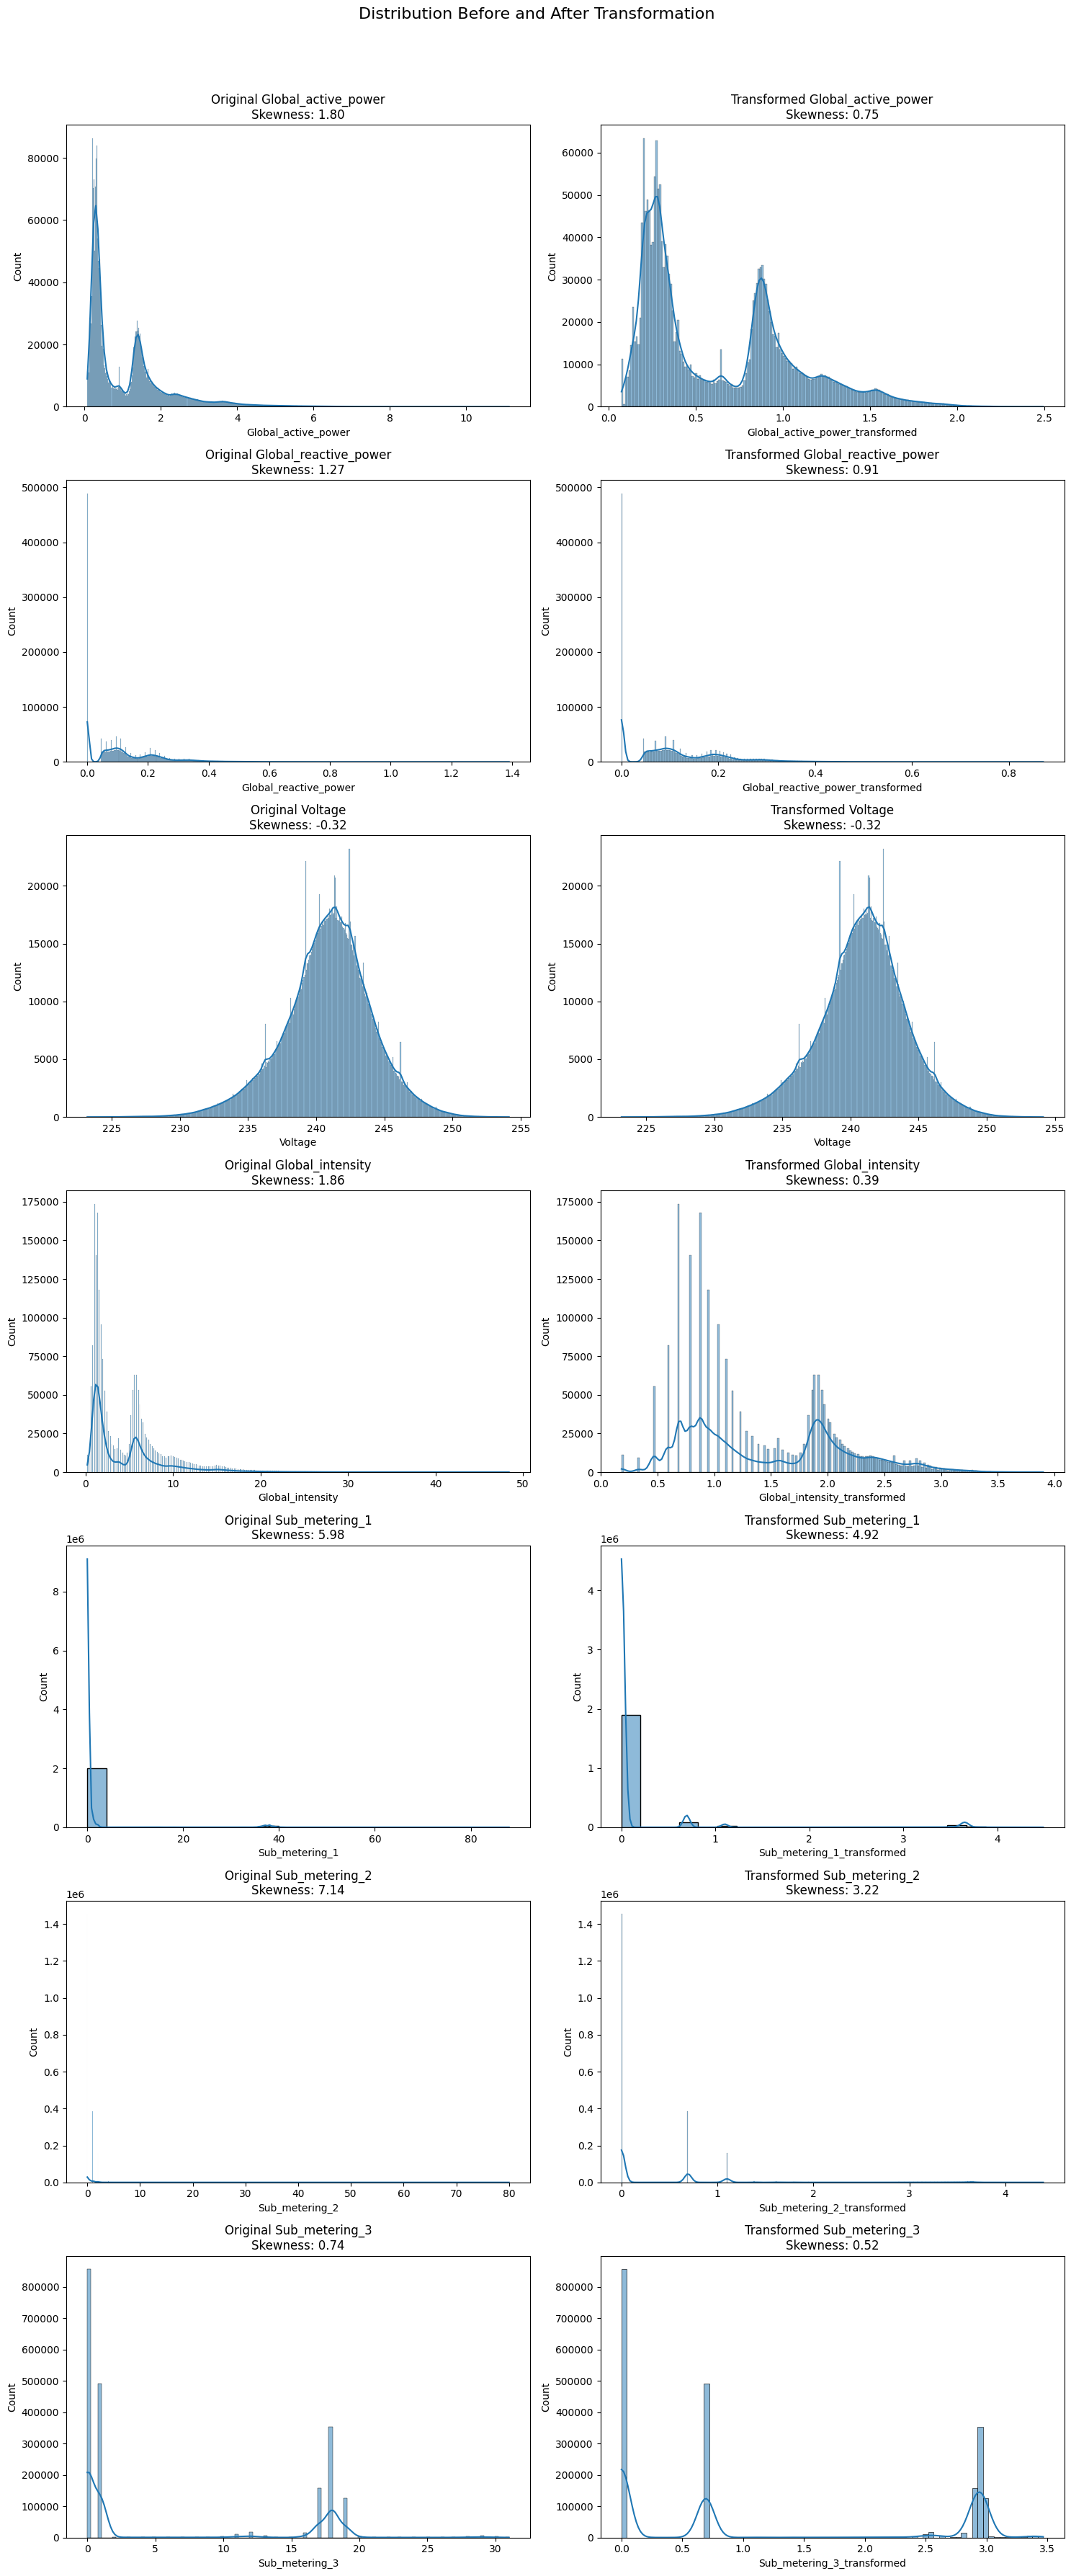


Skewness Report:
                       Original Skew Best Transform  Transformed Skew
Global_active_power         1.797454            log          0.746263
Global_reactive_power       1.265232            log          0.914156
Voltage                    -0.323726           None         -0.323726
Global_intensity            1.860937            log          0.394425
Sub_metering_1              5.983578            log          4.922522
Sub_metering_2              7.135711            log          3.220115
Sub_metering_3              0.736887            log          0.520851
Engineering additional features...
Calculating daily statistics...
Performing exploratory data analysis...
Creating daily consumption pattern plot...


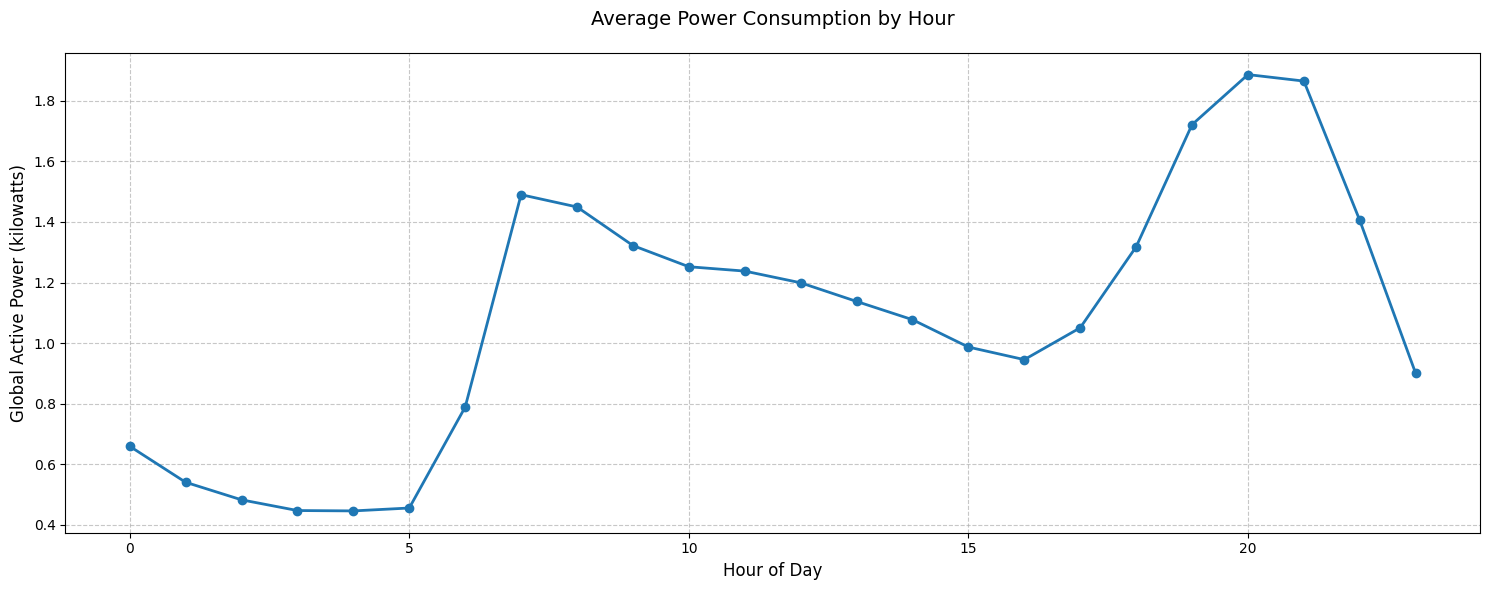

Creating weekly consumption pattern plot...


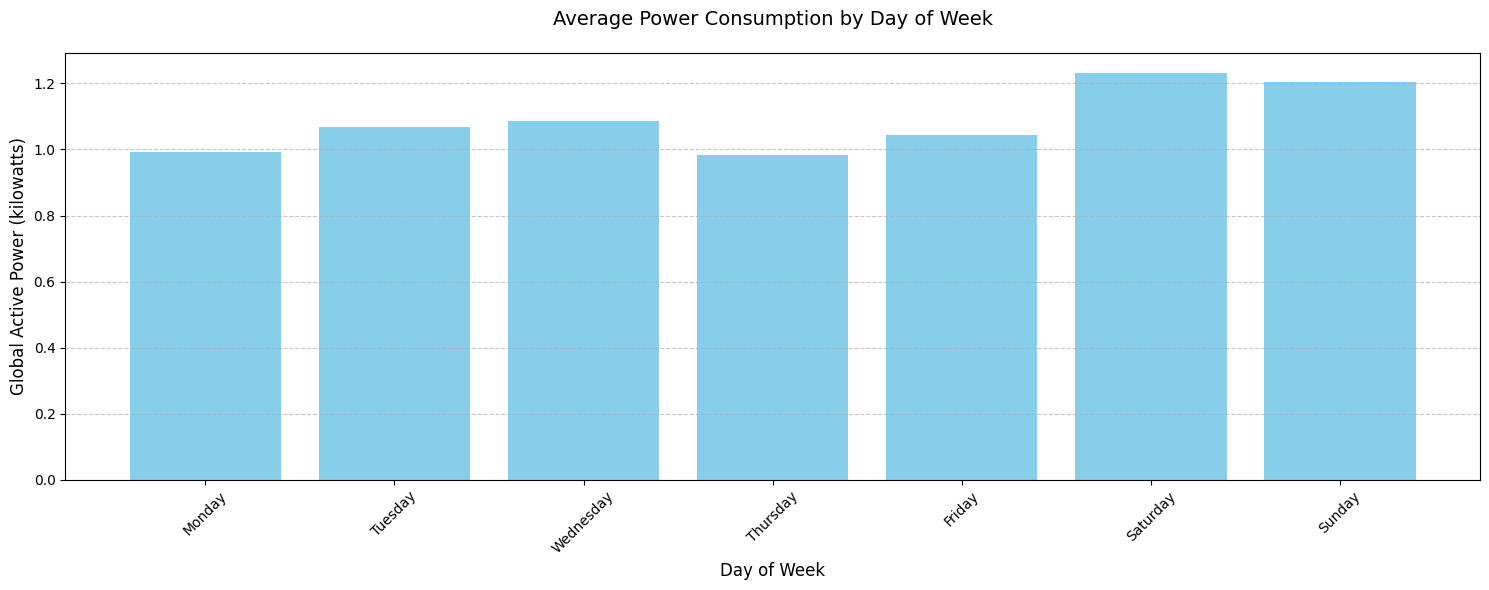

Creating monthly consumption pattern plot...


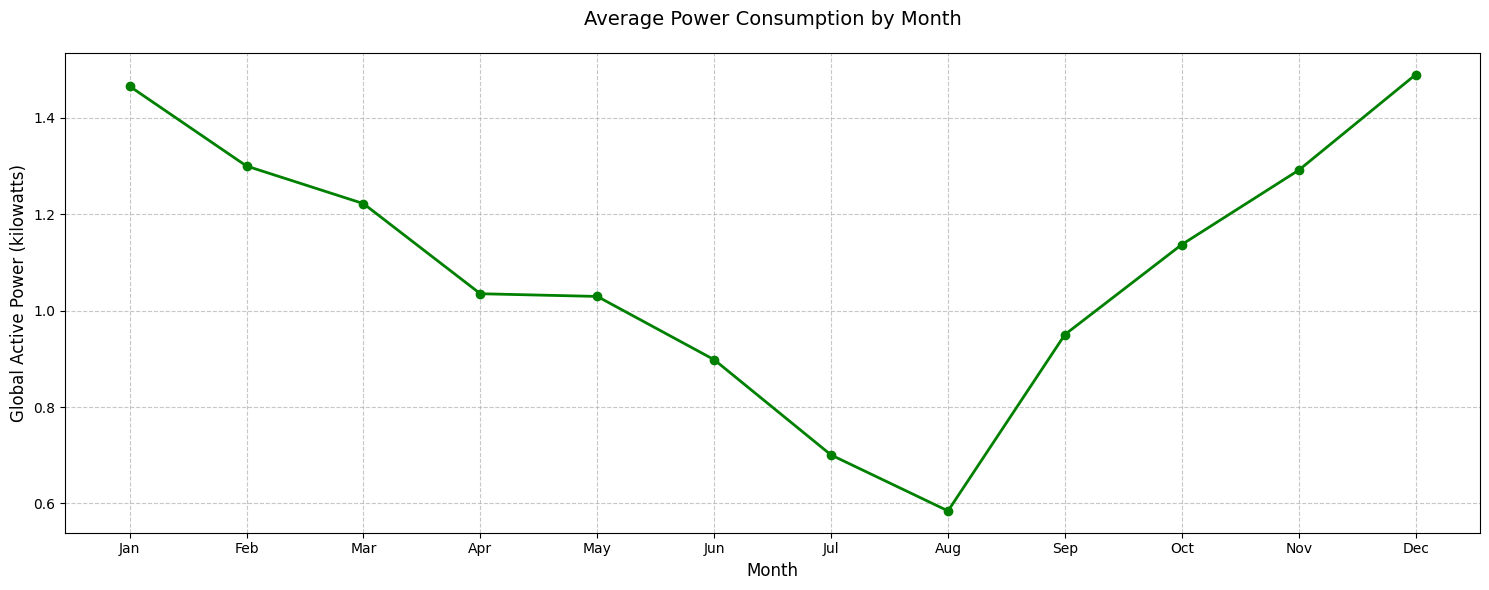


Summary Statistics for Global Active Power:
count    2.075259e+06
mean     1.086168e+00
std      1.053172e+00
min      7.600000e-02
25%      3.080000e-01
50%      5.980000e-01
75%      1.524000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

Peak vs Off-Peak Usage:
Peak Hours: 1.31 kW
Off-Peak Hours: 0.55 kW

Preparing data for modeling (using 100000 samples)...
Splitting data into train and test sets...
Scaling features...

Training Linear Regression...

Training Random Forest...

Random Forest Feature Importance:
                      feature  importance
6  Sub_metering_3_transformed    0.503705
4  Sub_metering_1_transformed    0.205322
5  Sub_metering_2_transformed    0.144836
0                        hour    0.071986
7                  daily_mean    0.049837
9                   daily_min    0.009692
8                   daily_max    0.006902
2                       month    0.005057
1                 day_of_week    0.002315
3                  is_weekend    0.00

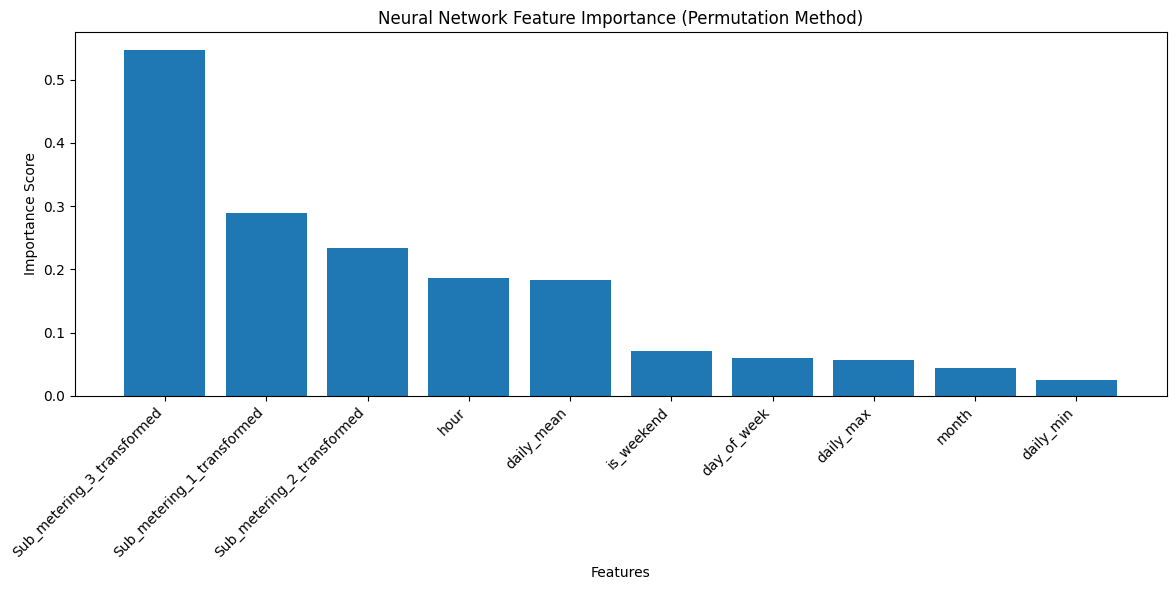


Neural Network Feature Importance:
                      feature  importance       std
6  Sub_metering_3_transformed    0.547775  0.002805
4  Sub_metering_1_transformed    0.289407  0.001120
5  Sub_metering_2_transformed    0.233740  0.001422
0                        hour    0.186131  0.001054
7                  daily_mean    0.182396  0.002661
3                  is_weekend    0.070637  0.000731
1                 day_of_week    0.058948  0.000983
8                   daily_max    0.056880  0.000830
2                       month    0.044588  0.000808
9                   daily_min    0.024315  0.000573

Comparing Model Performance:


<Figure size 1500x800 with 0 Axes>

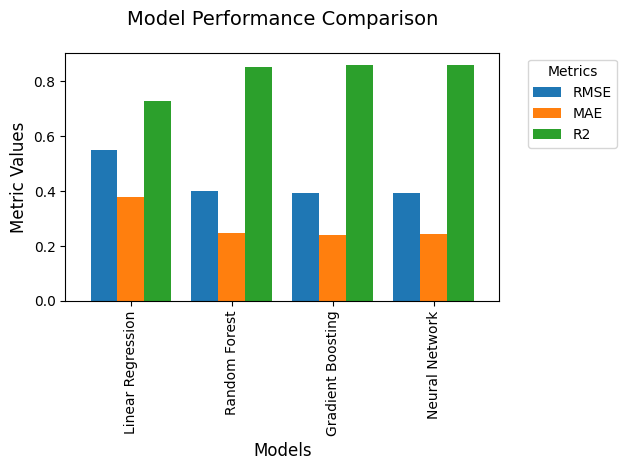


Detailed Model Comparison:
                     RMSE     MAE      R2
Linear Regression  0.5481  0.3783  0.7283
Random Forest      0.4018  0.2486  0.8540
Gradient Boosting  0.3920  0.2400  0.8610
Neural Network     0.3925  0.2449  0.8607

Best Overall Model: Gradient Boosting

Best Model Metrics:
RMSE: 0.3920
MAE: 0.2400
R2: 0.8610

Selected Gradient Boosting as the best model for this problem.
This selection is based on a composite score considering RMSE, MAE, and R2 metrics.

Analysis completed at: 2025-01-11 11:13:30
Total execution time: 0:04:57.627166


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def load_data(filepath):
    """Load and perform initial data exploration"""
    print("Loading dataset...")

    df = pd.read_csv(filepath, sep=';', parse_dates={'datetime': ['Date', 'Time']},
                     dayfirst=True, na_values=['?'])
    
    print(f"Dataset Shape: {df.shape}")
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nData Types:\n", df.dtypes)
    
    return df

def handle_skewness(df, numeric_columns):
    """Handle skewness in numeric features, optimized for speed"""
    print("Handling data skewness...")
    
    skewness_report = pd.DataFrame({
        'Original Skew': df[numeric_columns].skew()
    })
    
    transformed_columns = {}
    
    for column in numeric_columns:
        skewness = df[column].skew()
        
        if abs(skewness) > 0.5:  
            print(f"Handling skewness for {column} (skew: {skewness:.2f})")
            
            if skewness > 0:  
                df[f'{column}_transformed'] = np.log1p(df[column])  
            else:  
                df[f'{column}_transformed'] = -np.log1p(abs(df[column]))  
            
            transformed_skew = df[f'{column}_transformed'].skew()
            
            transformed_columns[column] = {
                'method': 'log' if transformed_skew < skewness else 'none',
                'original_skew': skewness,
                'transformed_skew': transformed_skew
            }

    skewness_report['Best Transform'] = [
        transformed_columns.get(col, {}).get('method', 'None') 
        for col in numeric_columns
    ]
    skewness_report['Transformed Skew'] = [
        transformed_columns.get(col, {}).get('transformed_skew', df[col].skew()) 
        for col in numeric_columns
    ]
    
    n_cols = len(numeric_columns)
    fig, axes = plt.subplots(n_cols, 2, figsize=(15, 5*n_cols))
    fig.suptitle('Distribution Before and After Transformation', fontsize=16, y=1.02)
    
    for idx, column in enumerate(numeric_columns):
        sns.histplot(df[column], kde=True, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Original {column}\nSkewness: {df[column].skew():.2f}')

        transformed_col = f'{column}_transformed' if f'{column}_transformed' in df.columns else column
        sns.histplot(df[transformed_col], kde=True, ax=axes[idx, 1])
        axes[idx, 1].set_title(f'Transformed {column}\nSkewness: {df[transformed_col].skew():.2f}')
    
    plt.tight_layout()
    plt.show()
    
    print("\nSkewness Report:")
    print(skewness_report)
    
    return df, transformed_columns

def preprocess_data(df):
    """Preprocess the data and create basic features"""
    print("Preprocessing data...")

    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)

    numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
                      'Sub_metering_3']
    
    print("Handling missing values...")
    for col in numeric_columns:
        df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

    df, transformed_columns = handle_skewness(df, numeric_columns)
    
    consumption_cols = [f'{col}_transformed' if col in transformed_columns else col 
                       for col in ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
    df['total_consumption'] = df[consumption_cols].sum(axis=1)
    
    return df, transformed_columns

def engineer_features(df):
    """Create advanced features for modeling"""
    print("Engineering additional features...")

    print("Calculating daily statistics...")
    df['daily_mean'] = df.groupby(df['datetime'].dt.date)['Global_active_power'].transform('mean')
    df['daily_max'] = df.groupby(df['datetime'].dt.date)['Global_active_power'].transform('max')
    df['daily_min'] = df.groupby(df['datetime'].dt.date)['Global_active_power'].transform('min')

    df['is_peak_hour'] = df['hour'].between(7, 23).astype(int)

    df['season'] = pd.cut(df['month'], 
                         bins=[0,3,6,9,12], 
                         labels=['Winter', 'Spring', 'Summer', 'Fall'])

    df['time_of_day'] = pd.cut(df['hour'],
                              bins=[-1, 6, 12, 18, 23],
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    return df

def perform_eda(df):
    """Perform exploratory data analysis and create visualizations"""
    print("Performing exploratory data analysis...")

    plt.style.use('default')

    print("Creating daily consumption pattern plot...")
    plt.figure(figsize=(15,6))
    daily_avg = df.groupby('hour')['Global_active_power'].mean()
    plt.plot(daily_avg.index, daily_avg.values, linewidth=2, marker='o')
    plt.title('Average Power Consumption by Hour', fontsize=14, pad=20)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Global Active Power (kilowatts)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Creating weekly consumption pattern plot...")
    plt.figure(figsize=(15,6))
    weekly_avg = df.groupby('day_of_week')['Global_active_power'].mean()
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    plt.bar(days, weekly_avg.values, color='skyblue')
    plt.title('Average Power Consumption by Day of Week', fontsize=14, pad=20)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('Global Active Power (kilowatts)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.tight_layout()
    plt.show()

    print("Creating monthly consumption pattern plot...")
    plt.figure(figsize=(15,6))
    monthly_avg = df.groupby('month')['Global_active_power'].mean()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.plot(months, monthly_avg.values, marker='o', linewidth=2, color='green')
    plt.title('Average Power Consumption by Month', fontsize=14, pad=20)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Global Active Power (kilowatts)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\nSummary Statistics for Global Active Power:")
    print(df['Global_active_power'].describe())

    peak_avg = df[df['is_peak_hour'] == 1]['Global_active_power'].mean()
    offpeak_avg = df[df['is_peak_hour'] == 0]['Global_active_power'].mean()
    print("\nPeak vs Off-Peak Usage:")
    print(f"Peak Hours: {peak_avg:.2f} kW")
    print(f"Off-Peak Hours: {offpeak_avg:.2f} kW")

def calculate_neural_network_feature_importance(model, X_train_scaled, y_train_scaled, features):
    """Calculate feature importance for neural network using permutation importance"""
    print("\nCalculating Neural Network Feature Importance...")
    
    result = permutation_importance(
        model, X_train_scaled, y_train_scaled,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': result.importances_mean,
        'std': result.importances_std
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.bar(importance_df['feature'], importance_df['importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Neural Network Feature Importance (Permutation Method)')
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return importance_df

def compare_and_select_best_model(results):
    """Compare all models and select the best one based on multiple metrics"""
    print("\nComparing Model Performance:")
    
    metrics_df = pd.DataFrame(results).T
    
    normalized_metrics = pd.DataFrame()
    normalized_metrics['RMSE_norm'] = (metrics_df['RMSE'] - metrics_df['RMSE'].min()) / (metrics_df['RMSE'].max() - metrics_df['RMSE'].min())
    normalized_metrics['MAE_norm'] = (metrics_df['MAE'] - metrics_df['MAE'].min()) / (metrics_df['MAE'].max() - metrics_df['MAE'].min())
    normalized_metrics['R2_norm'] = 1 - ((metrics_df['R2'] - metrics_df['R2'].min()) / (metrics_df['R2'].max() - metrics_df['R2'].min()))
    
    composite_scores = normalized_metrics.mean(axis=1)
    best_model = composite_scores.idxmin()
    
    plt.figure(figsize=(15, 8))
    metrics_df.plot(kind='bar', width=0.8)
    plt.title('Model Performance Comparison', fontsize=14, pad=20)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Metric Values', fontsize=12)
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print("\nDetailed Model Comparison:")
    print(metrics_df.round(4))
    
    print(f"\nBest Overall Model: {best_model}")
    print("\nBest Model Metrics:")
    for metric, value in results[best_model].items():
        print(f"{metric}: {value:.4f}")
    
    return best_model, results[best_model]

def train_models(df, features, sample_size=100000):
    """Train and evaluate machine learning models"""
    print(f"\nPreparing data for modeling (using {sample_size} samples)...")

    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df
    
    X = df_sample[features]
    y = df_sample['Global_active_power']

    print("Splitting data into train and test sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=42)

    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    mm_scaler = MinMaxScaler()
    y_train_scaled = mm_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(
            n_estimators=50,
            max_depth=10,
            min_samples_split=5,
            n_jobs=-1,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            min_samples_split=5,
            random_state=42
        ),
        'Neural Network': MLPRegressor(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=10
        )
    }
    
    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        if name == 'Neural Network':
            model.fit(X_train_scaled, y_train_scaled)
            y_pred_scaled = model.predict(X_test_scaled)
            y_pred = mm_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
            
            nn_importance = calculate_neural_network_feature_importance(
                model, X_train_scaled, y_train_scaled, features
            )
            print("\nNeural Network Feature Importance:")
            print(nn_importance)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

        results[name] = {
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        }

        if name in ['Random Forest', 'Gradient Boosting']:
            feature_importance = pd.DataFrame({
                'feature': features,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            print(f"\n{name} Feature Importance:")
            print(feature_importance)
    
    return results

def main():
    """Main execution function"""
    filepath = r"D:\Household\household_power_consumption.txt"  
    df = load_data(filepath)
    df, transformed_columns = preprocess_data(df)
    df = engineer_features(df)
    perform_eda(df)

    features = ['hour', 'day_of_week', 'month', 'is_weekend']
    numeric_features = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
                       'daily_mean', 'daily_max', 'daily_min']
    features.extend([f'{col}_transformed' if col in transformed_columns else col 
                    for col in numeric_features])
    
    results = train_models(df, features, sample_size=100000)
    best_model_name, best_model_metrics = compare_and_select_best_model(results)
    
    print(f"\nSelected {best_model_name} as the best model for this problem.")
    print("This selection is based on a composite score considering RMSE, MAE, and R2 metrics.")

if __name__ == "__main__":
    start_time = datetime.now()
    print(f"Analysis started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    try:
        main()
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
    finally:
        end_time = datetime.now()
        print(f"\nAnalysis completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Total execution time: {end_time - start_time}")


Analysis started at: 2025-01-10 17:39:25
Loading dataset...

Analyzing peak power usage periods...

Peak Power Usage Analysis:
Average Power Consumption: 1.092 kW
Peak Threshold: 1.536 kW

Identified Peak Hours:
Hour 19:00 - 20:00: 1.733 kW
Hour 20:00 - 21:00: 1.899 kW
Hour 21:00 - 22:00: 1.878 kW


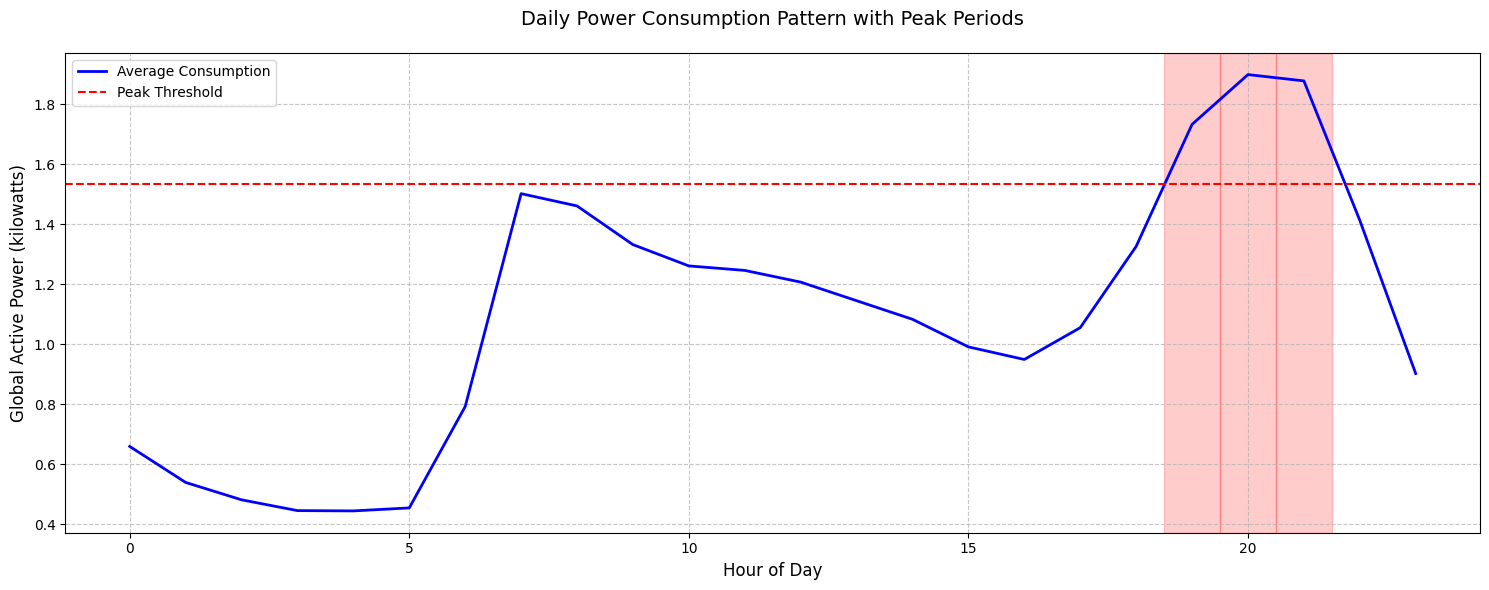


Detailed Power Usage Statistics:
                Average (kW)  Maximum (kW)  Minimum (kW)  Std Dev
Non-Peak Hours         0.985        11.122         0.078    0.964
Peak Hours             1.837        10.670         0.076    1.343

Peak Period Summary:
Number of Peak Hours per Day: 3
Average Energy Consumption during Peak Hours: 5.51 kWh

Current Time Status (13:13):
Period: OFF-PEAK
Average Power Usage for this Hour: 1.145 kW

Analysis completed at: 2025-01-10 17:39:44
Total execution time: 0:00:18.852212


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def load_data(filepath):
    """Load the dataset"""
    print("Loading dataset...")
    df = pd.read_csv(filepath, sep=';', parse_dates={'datetime': ['Date', 'Time']},
                     dayfirst=True, na_values=['?'])
    return df

def identify_peak_periods(df):
    """Identify and analyze peak power usage periods"""
    print("\nAnalyzing peak power usage periods...")

    hourly_avg = df.groupby(df['datetime'].dt.hour)['Global_active_power'].agg([
        'mean', 'count', 'std'
    ]).round(3)

    overall_mean = hourly_avg['mean'].mean()
    overall_std = hourly_avg['mean'].std()
    peak_threshold = overall_mean + overall_std
    
    peak_hours = hourly_avg[hourly_avg['mean'] > peak_threshold]

    print("\nPeak Power Usage Analysis:")
    print(f"Average Power Consumption: {overall_mean:.3f} kW")
    print(f"Peak Threshold: {peak_threshold:.3f} kW")
    print("\nIdentified Peak Hours:")

    for hour in peak_hours.index:
        print(f"Hour {hour:02d}:00 - {(hour+1):02d}:00: {peak_hours.loc[hour, 'mean']:.3f} kW")

    plt.figure(figsize=(15, 6))

    plt.plot(hourly_avg.index, hourly_avg['mean'], 'b-', linewidth=2, label='Average Consumption')

    plt.axhline(y=peak_threshold, color='r', linestyle='--', label='Peak Threshold')

    for hour in peak_hours.index:
        plt.axvspan(hour-0.5, hour+0.5, alpha=0.2, color='red')
    
    plt.title('Daily Power Consumption Pattern with Peak Periods', fontsize=14, pad=20)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Global Active Power (kilowatts)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    df['is_peak_hour'] = df['datetime'].dt.hour.isin(peak_hours.index)
    
    print("\nDetailed Power Usage Statistics:")
    stats = df.groupby('is_peak_hour')['Global_active_power'].agg([
        ('Average (kW)', 'mean'),
        ('Maximum (kW)', 'max'),
        ('Minimum (kW)', 'min'),
        ('Std Dev', 'std')
    ]).round(3)
    stats.index = ['Non-Peak Hours', 'Peak Hours']
    print(stats)

    total_peak_hours = len(peak_hours)
    peak_energy = df[df['is_peak_hour']]['Global_active_power'].mean() * total_peak_hours
    
    print(f"\nPeak Period Summary:")
    print(f"Number of Peak Hours per Day: {total_peak_hours}")
    print(f"Average Energy Consumption during Peak Hours: {peak_energy:.2f} kWh")

    current_hour = 13  
    current_status = "PEAK" if current_hour in peak_hours.index else "OFF-PEAK"
    print(f"\nCurrent Time Status (13:13):")
    print(f"Period: {current_status}")
    if current_hour in hourly_avg.index:
        print(f"Average Power Usage for this Hour: {hourly_avg.loc[current_hour, 'mean']:.3f} kW")

def main():
    filepath = r"D:\Household\household_power_consumption.txt"  
    df = load_data(filepath)
    identify_peak_periods(df)

if __name__ == "__main__":
    start_time = datetime.now()
    print(f"Analysis started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    try:
        main()
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
    finally:
        end_time = datetime.now()
        print(f"\nAnalysis completed at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Total execution time: {end_time - start_time}")


Loading data at: 2025-01-03 07:18:23

Energy Analysis Report - Generated at 2025-01-03 07:18:23

Key Metrics (kW):
Peak Hours Usage: 1.32
Off-Peak Usage: 0.54
Weekend Usage: 1.23
Weekday Usage: 1.04
Current Hour Average: 1.50

Cost Analysis:
Current Monthly Cost: USD 421359.99
Potential Monthly Savings: USD 30583.40


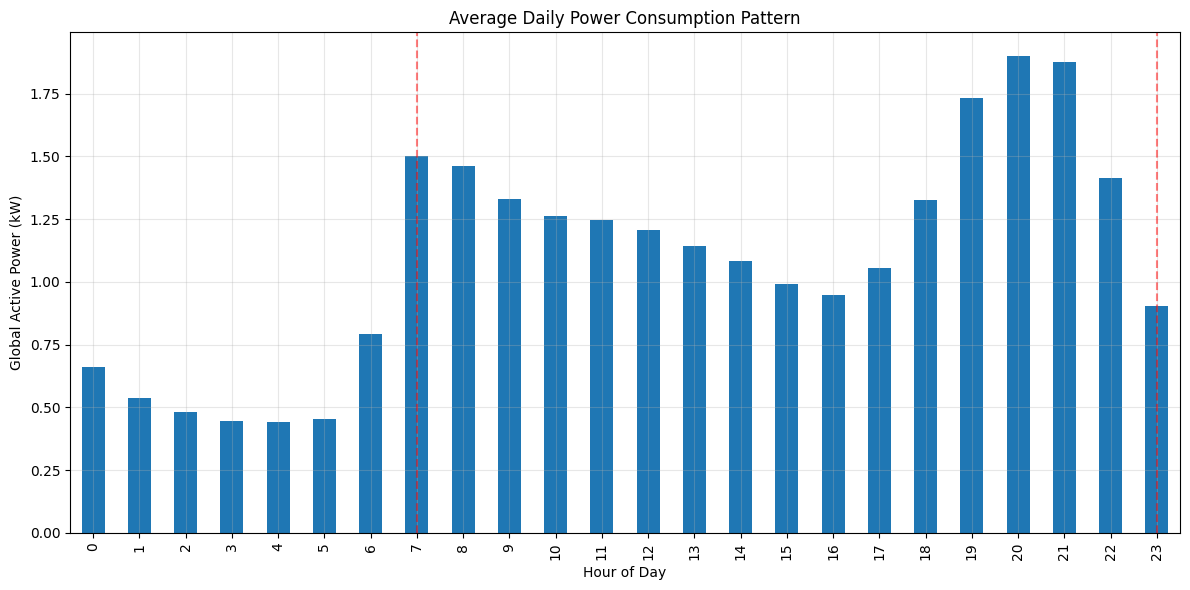


Detected 206576 anomalous readings


In [7]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

class TimeBasedEnergyAnalysis:
    def __init__(self):
        self.current_time = pd.Timestamp('2025-01-03 07:18:23')
        self.peak_hours_start = 7 
        self.peak_hours_end = 23   
        
    def load_and_preprocess_data(self, filepath):
        print(f"Loading data at: {self.current_time.strftime('%Y-%m-%d %H:%M:%S')}")

        df = pd.read_csv(filepath, sep=';', low_memory=False)

        df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], 
                                      format='%d/%m/%Y %H:%M:%S')

        df.drop(['Date', 'Time'], axis=1, inplace=True)
        df.set_index('datetime', inplace=True)

        df.replace('?', np.nan, inplace=True)
        numeric_columns = ['Global_active_power', 'Global_reactive_power',
                          'Voltage', 'Global_intensity', 'Sub_metering_1',
                          'Sub_metering_2', 'Sub_metering_3']
        
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
        return df

    def calculate_time_based_metrics(self, df):
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        df['is_weekend'] = df['day_of_week'].isin([5, 6])
        df['is_peak_hour'] = df['hour'].between(self.peak_hours_start, self.peak_hours_end)
        
        metrics = {
            'peak_usage': df[df['is_peak_hour']]['Global_active_power'].mean(),
            'off_peak_usage': df[~df['is_peak_hour']]['Global_active_power'].mean(),
            'weekend_usage': df[df['is_weekend']]['Global_active_power'].mean(),
            'weekday_usage': df[~df['is_weekend']]['Global_active_power'].mean(),
            'current_hour_avg': df[df.index.hour == self.current_time.hour]['Global_active_power'].mean()
        }
        
        return metrics

    def generate_hourly_profile(self, df):
        hourly_profile = df.groupby(df.index.hour)['Global_active_power'].agg([
            'mean', 'std', 'min', 'max'
        ]).round(3)
        
        return hourly_profile

    def calculate_cost_savings_potential(self, df, peak_rate=0.20, off_peak_rate=0.12):
        current_cost = (
            df[df['is_peak_hour']]['Global_active_power'].sum() * peak_rate +
            df[~df['is_peak_hour']]['Global_active_power'].sum() * off_peak_rate
        )

        potential_savings = (
            df[df['is_peak_hour']]['Global_active_power'].sum() * 0.20 * 
            (peak_rate - off_peak_rate)
        )
        
        return {'current_cost': current_cost, 'potential_savings': potential_savings}

    def detect_anomalies(self, df):
        model = IsolationForest(contamination=0.1, random_state=42)
        df['is_anomaly'] = model.fit_predict(df[['Global_active_power']])
        return df[df['is_anomaly'] == -1]

    def generate_report(self, df):
        print(f"\nEnergy Analysis Report - Generated at {self.current_time}")
        print("=" * 50)
        
        metrics = self.calculate_time_based_metrics(df)
        hourly_profile = self.generate_hourly_profile(df)
        cost_analysis = self.calculate_cost_savings_potential(df)
        
        print("\nKey Metrics (kW):")
        print(f"Peak Hours Usage: {metrics['peak_usage']:.2f}")
        print(f"Off-Peak Usage: {metrics['off_peak_usage']:.2f}")
        print(f"Weekend Usage: {metrics['weekend_usage']:.2f}")
        print(f"Weekday Usage: {metrics['weekday_usage']:.2f}")
        print(f"Current Hour Average: {metrics['current_hour_avg']:.2f}")
        
        print("\nCost Analysis:")
        print(f"Current Monthly Cost: USD {cost_analysis['current_cost']:.2f}")
        print(f"Potential Monthly Savings: USD {cost_analysis['potential_savings']:.2f}")
        
        self.plot_daily_pattern(df)
        
        return metrics, hourly_profile, cost_analysis

    def plot_daily_pattern(self, df):
        plt.figure(figsize=(12, 6))
        hourly_avg = df.groupby(df.index.hour)['Global_active_power'].mean()
        hourly_avg.plot(kind='bar')
        plt.title('Average Daily Power Consumption Pattern')
        plt.xlabel('Hour of Day')
        plt.ylabel('Global Active Power (kW)')
        plt.axvline(x=self.peak_hours_start, color='r', linestyle='--', alpha=0.5)
        plt.axvline(x=self.peak_hours_end, color='r', linestyle='--', alpha=0.5)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

def main():
    analyzer = TimeBasedEnergyAnalysis()
    
    try:
        df = analyzer.load_and_preprocess_data("household_power_consumption.txt")
        metrics, hourly_profile, cost_analysis = analyzer.generate_report(df)

        anomalies = analyzer.detect_anomalies(df)
        print(f"\nDetected {len(anomalies)} anomalous readings")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

if __name__ == "__main__":
    main()
